In [1]:
!pip install -q staintools opencv-python scikit-learn

  Preparing metadata (setup.py) ... done


In [2]:
!pip install spams-bin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 107.1 MB/s eta 0:00:0000:01:01


In [3]:
import os, cv2, random
import numpy as np
import tensorflow as tf
import staintools
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

2026-01-21 13:58:43.063758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769003923.319933      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769003923.390429      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769003923.948713      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769003923.948752      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769003923.948755      55 computation_placer.cc:177] computation placer alr

## Configuration

In [5]:
RAW_DATA_DIR = '/kaggle/input/oraldatasetone'
SPLIT_DIR = '/kaggle/working/dataset_split'
NORM_DIR  = '/kaggle/working/dataset_split_macenko'

CLASSES = ['Normal', 'OSCC']
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 30
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Collect image paths and labels

In [6]:
image_paths = []
labels = []

for label, cls in enumerate(CLASSES):
    cls_dir = Path(RAW_DATA_DIR) / cls
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(str(cls_dir / fname))
            labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print('Total images:', len(image_paths))

Total images: 5192


## 70 / 15 / 15 split

In [7]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels,
    test_size=0.30,
    stratify=labels,
    random_state=SEED
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.50,
    stratify=temp_labels,
    random_state=SEED
)

print('Train:', len(train_paths))
print('Val  :', len(val_paths))
print('Test :', len(test_paths))

Train: 3634
Val  : 779
Test : 779


## Create split folders

In [9]:
for split in ['train', 'val', 'test']:
    for cls in CLASSES:
        os.makedirs(f'{SPLIT_DIR}/{split}/{cls}', exist_ok=True)

## Copy images into splits

In [10]:
def copy_split(paths, labels, split):
    for p, l in zip(paths, labels):
        cls = CLASSES[l]
        dst = Path(SPLIT_DIR) / split / cls / Path(p).name
        cv2.imwrite(str(dst), cv2.imread(p))

copy_split(train_paths, train_labels, 'train')
copy_split(val_paths, val_labels, 'val')
copy_split(test_paths, test_labels, 'test')

## Macenko stain normalization (fit on TRAIN only)

In [14]:
ref_path = next(Path(f'{SPLIT_DIR}/train/OSCC').glob('*.jpg'))
ref_img = cv2.imread(str(ref_path))
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)

normalizer = staintools.StainNormalizer(method='macenko')
normalizer.fit(ref_img)

## Apply Macenko to train / val / test

In [15]:
for split in ['train', 'val', 'test']:
    for cls in CLASSES:
        in_dir = Path(SPLIT_DIR) / split / cls
        out_dir = Path(NORM_DIR) / split / cls
        out_dir.mkdir(parents=True, exist_ok=True)

        for img_path in in_dir.glob('*.jpg'):
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            norm = normalizer.transform(img)
            norm = cv2.cvtColor(norm, cv2.COLOR_RGB2BGR)
            cv2.imwrite(str(out_dir / img_path.name), norm)

## Load datasets

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    f'{NORM_DIR}/train', label_mode='binary',
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f'{NORM_DIR}/val', label_mode='binary',
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f'{NORM_DIR}/test', label_mode='binary',
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False
)

Found 3634 files belonging to 2 classes.


I0000 00:00:1769007805.611953      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769007805.615865      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 779 files belonging to 2 classes.
Found 779 files belonging to 2 classes.


## Model: EfficientNet-B0

In [30]:
base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(base.input, out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

## Training

In [31]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_auc",
            mode="max",
            patience=5,
            restore_best_weights=True
        )
    ]
)


Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 48s 129ms/step - accuracy: 0.5934 - auc: 0.6275 - loss: 0.6729 - val_accuracy: 0.7522 - val_auc: 0.8487 - val_loss: 0.4950
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7330 - auc: 0.8130 - loss: 0.5265 - val_accuracy: 0.7933 - val_auc: 0.8779 - val_loss: 0.4463
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7827 - auc: 0.8638 - loss: 0.4638 - val_accuracy: 0.7985 - val_auc: 0.8917 - val_loss: 0.4231
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7962 - auc: 0.8769 - loss: 0.4420 - val_accuracy: 0.8126 - val_auc: 0.9048 - val_loss: 0.3977
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8082 - auc: 0.8964 - loss: 0.4114 - val_accuracy: 0.8203 - val_auc: 0.9141 - val_loss: 0.3806
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8347 - auc: 0.9122 - loss: 0.3862 - val_accuracy: 0.8421 - val_auc: 0.9212 - val_loss: 0.3639
Epoch 7/30
228/228 ━━━━━━━━

In [32]:
model.save("/kaggle/working/oscc_last_epoch.keras")

## Final TEST evaluation

In [33]:
y_true, y_prob = [], []

for x, y in test_ds:
    p = model.predict(x, verbose=0)
    y_prob.extend(p.flatten())
    y_true.extend(y.numpy().flatten())

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob > 0.5).astype(int)

print('AUC:', roc_auc_score(y_true, y_prob))
print(classification_report(y_true, y_pred, target_names=CLASSES))

cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', cm)

AUC: 0.965735789265201
              precision    recall  f1-score   support

      Normal       0.89      0.93      0.91       374
        OSCC       0.93      0.89      0.91       405

    accuracy                           0.91       779
   macro avg       0.91      0.91      0.91       779
weighted avg       0.91      0.91      0.91       779

Confusion Matrix:
 [[346  28]
 [ 43 362]]


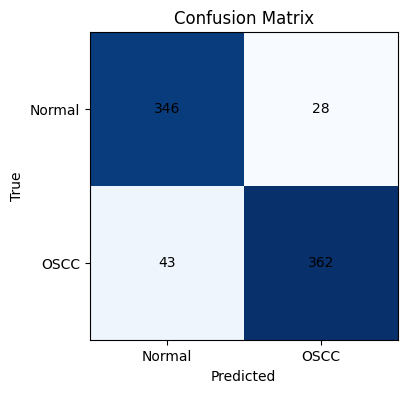

In [34]:
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.xticks([0,1], CLASSES)
plt.yticks([0,1], CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

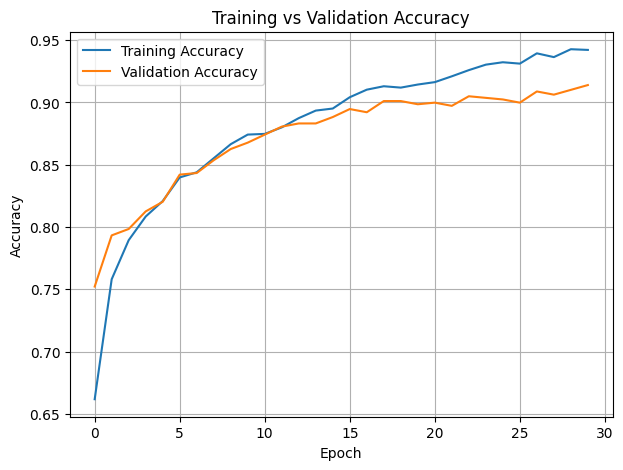

In [35]:
plt.figure(figsize=(7,5))

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()


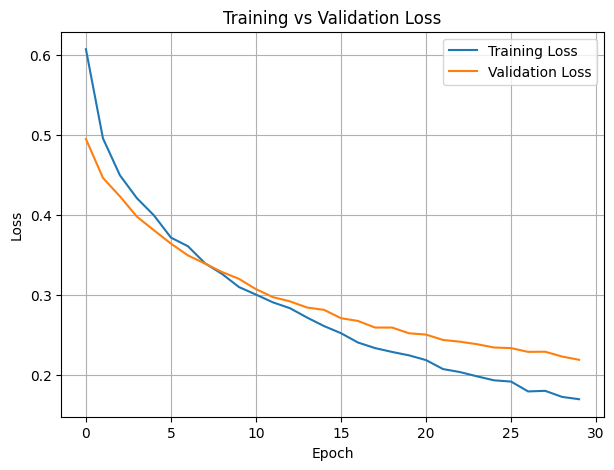

In [36]:
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
